<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/AI%20study/%EC%B9%98%EC%95%84/tooth_CNN_210815.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tooth_CNN

In [3]:
import tensorflow as tf
# Ture가 나와야 GPU가 작동 되는 중 !
from tensorflow.python.client import device_lib 
device_lib.list_local_devices() 
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

(256, 360)

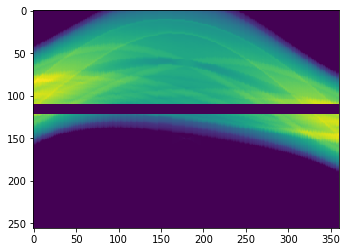

In [29]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras import datasets, layers, models

### 마스크, metal_line, padding, y_shape 설정 ----------------------------------
df_line = pd.read_table('./images/sino_examples/metal_point2.txt', sep = ',', header = None)
df = pd.read_table('./images/sino_examples/sino_wmetal.txt', sep = ',', header = None)

mask_list = []

for i in range(360):
  temp = []
  for i, k in zip(df.iloc[:, i]== 200, df.iloc[:, i].index):
    if i == True:
      temp.append(k)
  mask_list.append(temp)

y_shape = 0
padding = 0
metal_line = []
count = 0
for i in mask_list[:]:
  mid = int((max(i) - min(i))/2)

  if max(i) - min(i) > y_shape:
    y_shape = max(i) - min(i)

  if mid > padding:
    padding = mid

  if (max(i)-min(i)) % 2 == 0:
    metal_line.append(min(i) + mid)

  else:
    metal_line.append(min(i) + mid + 1)

  count += 1
metal_shift = [i - min(metal_line) for i in metal_line]
### ----------------------------------------------------------------

# parameter
image_num = [0, 1, 2, 3, 4, 5, 6, 7, 8]       # 전체 이미지
train_image_num = [1, 2, 3, 4, 5, 6, 7, 8]    # 트레이닝 이미지 범위 [1, 2, 3, 4, 5, 6, 7, 8]
# test_image_num = 0                            # 테스트 이미지 숫자 [0]
X_shape = [20, 21]                            # X 형태 [행, 열] -> 트레이닝 크기
# y_shape = 5                                   # y 형태 -> 트레이닝 결과 크기
# y_test_range = [100, 110]                     # y_test 예측 범위 [100 ~ 110]
epoch = 1000                                  # epoch 횟수

# metal_line = pd.read_table('./images/sino_examples/metal_point.txt', sep = ',', header = None)


for i, j, k in zip(df.columns, metal_shift, metal_line):
      df.iloc[k - 1 - padding : k + padding + 1, i] = 200
      df[i] = df[i].shift(-j, fill_value = 0)
    
y_test_range = [min(df[df.iloc[:, 0] == 200].index), max(df[df.iloc[:, 0] == 200].index)]

df.iloc[y_test_range[0] : y_test_range[1] + 1, :] = 0
df = df / math.ceil(df.max().max())
    
plt.imshow(df)

df.shape

In [30]:
for num in image_num: 
    globals()['df{}'.format(num)] = pd.read_table('./images/sino_examples/sino_{}.txt'.format(num),sep=',', header = None)
    for i, j in zip(globals()['df{}'.format(num)].columns, metal_shift):
      globals()['df{}'.format(num)][i] = globals()['df{}'.format(num)][i].shift(-j, fill_value = 0)
    globals()['df{}'.format(num)] = globals()['df{}'.format(num)] / math.ceil(globals()['df{}'.format(num)].max().max())


# train셋, test셋으로 나누어 줍니다. X는 입력 변수, y는 출력 변수
X_train_org, X_test_org, y_train_org, y_test_org = [], [], [], []

# X 형태 (x_shape[0]/2 + x_shape[0]/2, x_shape[1]), y 형태 (y_shape)
for num in train_image_num:
    for i in range(360 - X_shape[1]):                             # i, 열, 1
        for j in range(256 - X_shape[0] - y_shape):                # j, 행, 0
            X_train_org.append(pd.concat([globals()['df{}'.format(num)].iloc[j:j+int(X_shape[0]/2), 0+i:X_shape[1]+i], globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2)+y_shape:j+int(X_shape[0]/2)+y_shape+int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))           # 아래
            if X_shape[1] % 2 == 0:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)])
            else:
                y_train_org.append(globals()['df{}'.format(num)].iloc[j+int(X_shape[0]/2):j+int(X_shape[0]/2)+y_shape, i+int(X_shape[1]/2)+1])

for i in range(360 - X_shape[1]):
    X_test_org.append(pd.concat([df.iloc[y_test_range[0] - int(X_shape[0]/2):y_test_range[0], 0+i:X_shape[1]+i], df.iloc[y_test_range[1]:y_test_range[1] + int(X_shape[0]/2), 0+i:X_shape[1]+i]], axis = 0))
    if X_shape[1] % 2 == 0:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)])
    else:
        y_test_org.append(df.iloc[y_test_range[0]:y_test_range[1], i+int(X_shape[1]/2)+1])

X_train_org, X_test_org, y_train_org, y_test_org = np.array(X_train_org), np.array(X_test_org), np.array(y_train_org), np.array(y_test_org)

# RGB 값을 추가 합니다. 우선 흑백으로 설정 하였습니다.
# train 형태 : ((8*354*245, x_shape[0], x_shape[1], 1)), test 형태 : ((354, x_shape[0], x_shape[1], 1))
# tensorflow는 3차원만 지원하므로 3차원 형태로 reshape 해줘야 합니다.
X_train = X_train_org.reshape((len(train_image_num)*(360-X_shape[1])*(256-X_shape[0]-y_shape), X_shape[0], X_shape[1], 1))
X_test = X_test_org.reshape(((360-X_shape[1]), X_shape[0], X_shape[1], 1))
y_train = y_train_org
y_test = y_test_org

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(X_shape[0], X_shape[1], 1)))
# MaxPooling2D(filter)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(y_shape))
model.summary()

# model 구성
model.compile(optimizer='adam',
            loss='mse',
            metrics=['accuracy'])

model.fit(X_train, y_train, epochs=epoch, verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):360-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2)+1:360-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 18, 19, 32)        320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 1, 1, 64)          36928     
_________________________________________________________________
flatten_8 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5942e-04 - accuracy: 0.4174
Epoch 820/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5894e-04 - accuracy: 0.4181
Epoch 823/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.5887e-04 - accuracy: 0.4190
Epoch 824/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5861e-04 - accuracy: 0.4180
Epoch 825/1000
12839/19069 [===================>..........] - ETA: 11s - loss: 1.5806e-04 - accuracy: 0.4158

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5876e-04 - accuracy: 0.4181
Epoch 831/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5831e-04 - accuracy: 0.4163
Epoch 832/1000
19069/19069 [==============================] - 37s 2ms/step - loss: 1.6002e-04 - accuracy: 0.4220
Epoch 833/1000
 9640/19069 [==============>...............] - ETA: 17s - loss: 1.5980e-04 - accuracy: 0.418

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.6177e-04 - accuracy: 0.4158
Epoch 837/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.6427e-04 - accuracy: 0.4231
Epoch 840/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5687e-04 - accuracy: 0.4204
Epoch 841/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5991e-04 - accuracy: 0.4176
Epoch 842/1000
 4848/19069 [======>.......................] - ETA: 25s - loss: 1.5596e-04 - accuracy: 0.4203

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5809e-04 - accuracy: 0.4165
Epoch 846/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.6072e-04 - accuracy: 0.4155
Epoch 849/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5987e-04 - accuracy: 0.4165
Epoch 850/1000
19069/19069 [==============================] - 37s 2ms/step - loss: 1.5918e-04 - accuracy: 0.4205
Epoch 851/1000
  673/19069 [>.............................] - ETA: 33s - loss: 1.6468e-04 - accuracy: 0.430

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5955e-04 - accuracy: 0.4181
Epoch 858/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5908e-04 - accuracy: 0.4169
Epoch 859/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5805e-04 - accuracy: 0.4189
Epoch 860/1000
10698/19069 [===============>..............] - ETA: 15s - loss: 1.5839e-04 - accuracy: 0.416

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 37s 2ms/step - loss: 1.5888e-04 - accuracy: 0.4147
Epoch 862/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.6128e-04 - accuracy: 0.4166
Epoch 863/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.5910e-04 - accuracy: 0.4165
Epoch 864/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5829e-04 - accuracy: 0.4161
Epoch 865/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5812e-04 - accuracy: 0.4184
Epoch 866/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5865e-04 - accuracy: 0.4191
Epoch 867/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5998e-04 - accuracy: 0.4172
Epoch 868/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.6006e-04 - accuracy: 0.4164
Epoch 872/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5898e-04 - accuracy: 0.416

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5771e-04 - accuracy: 0.4162
Epoch 877/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5963e-04 - accuracy: 0.4228
Epoch 880/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.6005e-04 - accuracy: 0.4205
Epoch 881/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5909e-04 - accuracy: 0.4186
Epoch 882/1000
 5386/19069 [=======>......................] - ETA: 24s - loss: 1.5702e-04 - accuracy: 0.4152

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 37s 2ms/step - loss: 1.6074e-04 - accuracy: 0.4184
Epoch 886/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.6024e-04 - accuracy: 0.4158
Epoch 889/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5998e-04 - accuracy: 0.4154
Epoch 890/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5872e-04 - accuracy: 0.4203
Epoch 891/1000
  601/19069 [..............................] - ETA: 33s - loss: 1.5720e-04 - accuracy: 0.4109

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5998e-04 - accuracy: 0.4191
Epoch 895/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5934e-04 - accuracy: 0.4194
Epoch 898/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5771e-04 - accuracy: 0.4182
Epoch 899/1000
13575/19069 [====================>.........] - ETA: 10s - loss: 1.5771e-04 - accuracy: 0.4180

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 35s 2ms/step - loss: 1.5997e-04 - accuracy: 0.4171
Epoch 907/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.6089e-04 - accuracy: 0.4153
Epoch 908/1000
19069/19069 [==============================] - 37s 2ms/step - loss: 1.5878e-04 - accuracy: 0.4173
Epoch 909/1000
 3639/19069 [====>.........................] - ETA: 28s - loss: 1.5785e-04 - accuracy: 0.4196

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 34s 2ms/step - loss: 1.6023e-04 - accuracy: 0.4173
Epoch 912/1000
19069/19069 [==============================] - 38s 2ms/step - loss: 1.6591e-04 - accuracy: 0.4115
Epoch 916/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5895e-04 - accuracy: 0.4190
Epoch 917/1000
18467/19069 [============================>.] - ETA: 1s - loss: 1.6177e-04 - accuracy: 0.41

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 35s 2ms/step - loss: 1.5916e-04 - accuracy: 0.4190
Epoch 924/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5909e-04 - accuracy: 0.4164
Epoch 925/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.6224e-04 - accuracy: 0.4223
Epoch 926/1000
10679/19069 [===============>..............] - ETA: 15s - loss: 1.5892e-04 - accuracy: 0.4169

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5879e-04 - accuracy: 0.4147
Epoch 932/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.5727e-04 - accuracy: 0.4156
Epoch 933/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.6208e-04 - accuracy: 0.4168
Epoch 934/1000
 8903/19069 [=============>................] - ETA: 18s - loss: 1.5564e-04 - accuracy: 0.420

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 35s 2ms/step - loss: 1.5822e-04 - accuracy: 0.4142
Epoch 938/1000
19069/19069 [==============================] - 40s 2ms/step - loss: 1.5718e-04 - accuracy: 0.4185
Epoch 942/1000
19069/19069 [==============================] - 38s 2ms/step - loss: 1.5918e-04 - accuracy: 0.4169
Epoch 943/1000
13463/19069 [====================>.........] - ETA: 10s - loss: 1.5849e-04 - accuracy: 0.420

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 35s 2ms/step - loss: 1.5920e-04 - accuracy: 0.4172
Epoch 949/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5927e-04 - accuracy: 0.4160
Epoch 950/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5702e-04 - accuracy: 0.4182
Epoch 951/1000
 9645/19069 [==============>...............] - ETA: 18s - loss: 1.5644e-04 - accuracy: 0.4191

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 34s 2ms/step - loss: 1.5928e-04 - accuracy: 0.4183
Epoch 955/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.5957e-04 - accuracy: 0.4164
Epoch 959/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5720e-04 - accuracy: 0.4183
Epoch 960/1000
19069/19069 [==============================] - 34s 2ms/step - loss: 1.5676e-04 - accuracy: 0.4176
Epoch 961/1000
 5310/19069 [=======>......................] - ETA: 25s - loss: 1.5649e-04 - accuracy: 0.4181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 38s 2ms/step - loss: 1.5683e-04 - accuracy: 0.4152
Epoch 964/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5844e-04 - accuracy: 0.4181
Epoch 968/1000
19069/19069 [==============================] - 36s 2ms/step - loss: 1.5782e-04 - accuracy: 0.4165
Epoch 969/1000
18529/19069 [============================>.] - ETA: 0s - loss: 1.5755e-04 - accuracy: 0.4181

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 35s 2ms/step - loss: 1.6044e-04 - accuracy: 0.4175
Epoch 973/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5834e-04 - accuracy: 0.4199
Epoch 976/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5782e-04 - accuracy: 0.4190
Epoch 977/1000
17796/19069 [==========================>...] - ETA: 2s - loss: 1.5960e-04 - accuracy: 0.41

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 36s 2ms/step - loss: 1.5914e-04 - accuracy: 0.4149
Epoch 984/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5755e-04 - accuracy: 0.4187
Epoch 985/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5872e-04 - accuracy: 0.4162
Epoch 986/1000
13750/19069 [====================>.........] - ETA: 9s - loss: 1.6003e-04 - accuracy: 0.4169

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19069/19069 [==============================] - 35s 2ms/step - loss: 1.5676e-04 - accuracy: 0.4182
Epoch 993/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5761e-04 - accuracy: 0.4101
Epoch 994/1000
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5855e-04 - accuracy: 0.4191
Epoch 995/1000
11639/19069 [=================>............] - ETA: 13s - loss: 1.5697e-04 - accuracy: 0.419

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



12156/19069 [==================>...........] - ETA: 12s - loss: 1.5898e-04 - accuracy: 0.4152

Epoch 1/5
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5963e-04 - accuracy: 0.4159
Epoch 2/5
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5641e-04 - accuracy: 0.4130
Epoch 3/5
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5824e-04 - accuracy: 0.4174
Epoch 4/5
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5842e-04 - accuracy: 0.4126
Epoch 5/5
19069/19069 [==============================] - 35s 2ms/step - loss: 1.5736e-04 - accuracy: 0.4213
11/11 - 0s - loss: 0.1676 - accuracy: 0.2743
0.2743362784385681


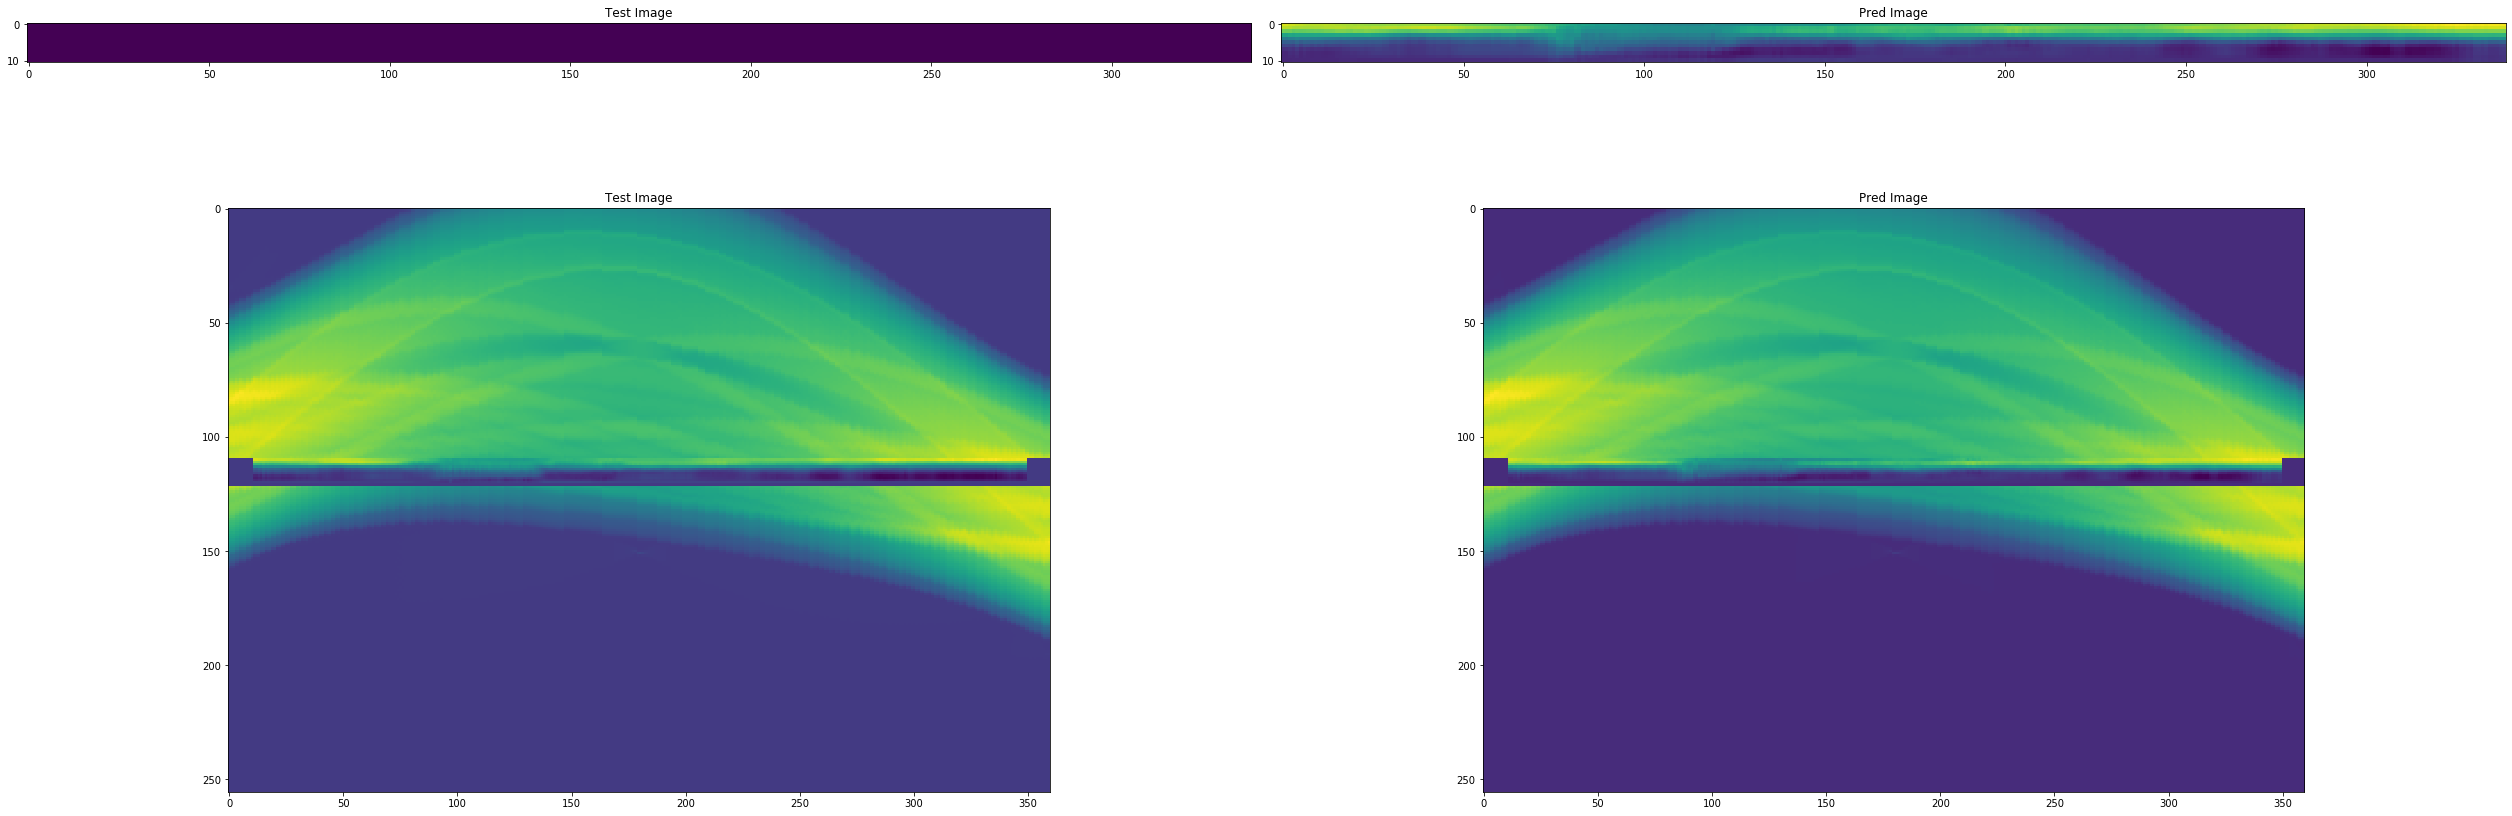

In [32]:
# 중간에 돌아가던 도중 끊겨서 이어서 남은 5개만 더 돌렸습니다.
model.fit(X_train, y_train, epochs=5, verbose = 1)

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)      # test 데이터를 넣었을 때의 loss, acc
print(test_acc)   # 정확도

# 모델 예측
pred = model.predict(X_test)    # 예측 데이터를 ()안에 넣으면 됩니다.

figure, axes = plt.subplots(nrows=2, ncols=2, figsize = (35, 15))
axes[0][0].set_title('Test Image')
axes[0][0].imshow(y_test_org.T)
axes[0][1].set_title('Pred Image')
axes[0][1].imshow(pred.T)
axes[1][0].set_title('Test Image')
axes[1][0].imshow(df)
df_test_img = df
if X_shape[1] % 2 == 0:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2):360-int(X_shape[1]/2)] = pred.T
else:
    df_test_img.iloc[y_test_range[0]:y_test_range[1], 0+int(X_shape[1]/2)+1:360-int(X_shape[1]/2)] = pred.T
axes[1][1].set_title('Pred Image')
axes[1][1].imshow(df_test_img)
figure.colorbar;

figure.tight_layout()
plt.show()

# 예측 범위가 넓어서 그런지 예측 값이 별로 좋지 않네요...

이전 예측 범위는 5 -> 현재 예측 범위가 11

파라미터들을 수정해서 모델을 고치거나, 예측 범위를 줄여야 할것 같아요 !

In [33]:
# 주신 line이랑 제가 따로 중심부분만 딴 부분이랑 중간 중간 몇군데씩 안맞는 부분 있어서 제가 따로 딴 line을 사용 했습니다.
df_line == [i - min(metal_line) for i in metal_line]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359
0,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True


In [ ]:
# mat 저장
import scipy.io as sio
# sio.savemat('df_test_img.mat', {'values' : df_test_img.values})